# **<font color="blue"> RandomForest</font>**

In [ ]:
!pip install optuna

In [ ]:
# Tratamiento de datos
import numpy as np
import pandas as pd
# Gráficos
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['font.size'] = 8
# Preprocesado y modelado
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from joblib import Parallel, delayed, cpu_count
import optuna

# Configuración warnings
import warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)
print(f"Versión de scikit-learn: {sklearn.__version__}")

Versión de scikit-learn: 1.5.2


In [ ]:
# cargando los datos
Boston= pd.read_csv("Boston.csv",sep=";")
display(Boston.head(5))
display(Boston.info())

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  black    506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


None

In [ ]:
Boston['chas'] = Boston['chas'].astype('object')

In [ ]:
# División de los datos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(
                                        Boston.drop(columns="medv"),
                                        Boston['medv'],
                                        test_size = 0.20,
                                        random_state = 123
                                    )

print(f"Tamaño conjunto entrenamiento: {X_train.shape[0]}")
print(f"Tamaño conjunto test: {X_test.shape[0]}")


Tamaño conjunto entrenamiento: 404
Tamaño conjunto test: 102


Los parámetros e hiperparámetros empleados por defecto son:

n_estimators=100

criterion='squared_error'

max_depth=None

min_samples_split=2

min_samples_leaf=1

min_weight_fraction_leaf=0.0

max_features=1.0

max_leaf_nodes=None

min_impurity_decrease=0.0

bootstrap=True

oob_score=False

n_jobs=None

random_state=None

verbose=0

warm_start=False

ccp_alpha=0.0

max_samples=None

De entre todos ellos, destacan aquellos que detienen el crecimiento de los árboles, los que controlan el número de árboles y predictores incluidos, y los que gestionan la paralelización:

<font color="Blue"> n_estimators: </font> número de árboles incluidos en el modelo

<font color="Blue"> max_depth: </font> profundidad máxima que pueden alcanzar los árboles.

<font color="Blue"> min_samples_split: </font> número mínimo de observaciones que debe de tener un nodo para que pueda dividirse. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento ceil(min_samples_split * n_samples).

<font color="Blue"> min_samples_leaf: </font> número mínimo de observaciones que debe de tener cada uno de los nodos hijos para que se produzca la división. Si es un valor decimal se interpreta como fracción del total de observaciones de entrenamiento ceil(min_samples_split * n_samples).

<font color="Blue">max_leaf_nodes:</font> número máximo de nodos terminales que pueden tener los árboles.

<font color="Blue">max_features:</font> número de predictores considerados a en cada división. Puede ser:

Un valor entero

Una fracción del total de predictores..

“sqrt”, raiz cuadrada del número total de predictores.

“log2”, log2 del número total de predictores.

None, utiliza todos los predictores.

<font color="Blue">oob_score</font> Si se calcula o no el out-of-bag R^2. Por defecto es False ya que aumenta el tiempo de entrenamiento.

<font color="Blue">n_jobs:</font> número de cores empleados para el entrenamiento. En random forest los árboles se ajustan de forma independiente, por lo la paralelización reduce notablemente el tiempo de entrenamiento. Con -1 se utilizan todos los cores disponibles.

<font color="Blue">random_state</font> semilla para que los resultados sean reproducibles. Tiene que ser un valor entero.

In [ ]:
# Creación del modelo
modelo = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 1,
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

# Entrenamiento del modelo
modelo.fit(X_train, y_train)

RandomForestRegressor(max_features=1, n_estimators=10, n_jobs=-1,
                      random_state=123)

In [ ]:
# PREDICCION Y EVALUACION DEL MODELO
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelo.predict(X=X_test)
rmse = root_mean_squared_error(y_true=y_test, y_pred=predicciones)
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 4.334131525280626


Optimización de hiperparámetros

El modelo inicial se ha entrenado utilizando 10 árboles (n_estimators=10) y manteniendo el resto de hiperparámetros con su valor por defecto. Al ser hiperparámetros, no se puede saber de antemano cuál es el valor más adecuado, la forma de identificarlos es mediante el uso de estrategias de validación, por ejemplo validación cruzada.

Los modelos Random Forest tienen la ventaja de disponer del Out-of-Bag error, lo que permite obtener una estimación del error de test sin recurrir a la validación cruzada, que es computacionalmente costosa. En la implementación de RandomForestRegressor, la métrica devuelta como oob_score es el  R2, si se desea otra, se tiene que recurrir al método oob_decision_function_() para obtener las predicciones y con ellas calcular la métrica de interés. Para una explicación más detallada consultar: Grid search de modelos Random Forest con out-of-bag error y early stopping.

Cabe tener en cuenta que, cuando se busca el valor óptimo de un hiperparámetro con dos métricas distintas, el resultado obtenido raramente es el mismo. Lo importante es que ambas métricas identifiquen las mismas regiones de interés.

Número de árboles

En Random Forest, el número de árboles no es un hiperparámetro crítico en cuanto que, añadir árboles, solo puede hacer que mejorar el resultado. En Random Forest no se produce overfitting por exceso de árboles. Sin embargo, añadir árboles una vez que la mejora se estabiliza es una perdida te recursos computacionales.

Valor óptimo de n_estimators: 126


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


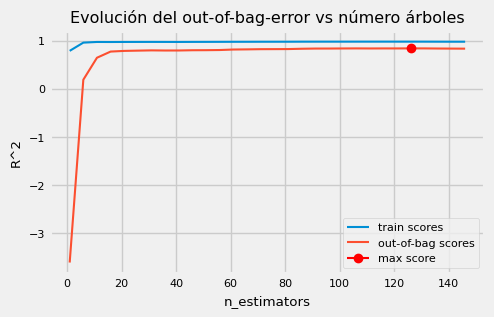

In [ ]:
# Validación empleando el Out-of-Bag error
warnings.filterwarnings('ignore')
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.
for n_estimators in estimator_range:
    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 1,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmax(oob_scores)]}")
warnings.filterwarnings('default')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Valor óptimo de n_estimators: 66


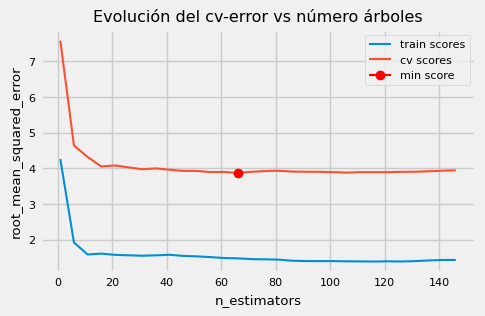

In [ ]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
estimator_range = range(1, 150, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de k-cross-validation.
for n_estimators in estimator_range:

    modelo = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = 1,
                oob_score    = False,
                n_jobs       = -1,
                random_state = 123
             )

    # Error de entrenamiento
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X=X_train)
    rmse = root_mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
           )
    train_scores.append(rmse)

    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, cv_scores, label="cv scores")
ax.plot(estimator_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del cv-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators: {estimator_range[np.argmin(cv_scores)]}")

Si bien el valor óptimo de las métricas se alcanza con 126 y 66 árboles, las curvas indican que, a partir de 18 árboles, el error de validación del modelo se estabiliza

**Max features**

El valor de máx_features es uno de los hiperparámetros más importantes de random forest, ya que es el que permite controlar cuánto se decorrelacionan los árboles entre sí.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Valor óptimo de max_features: 9


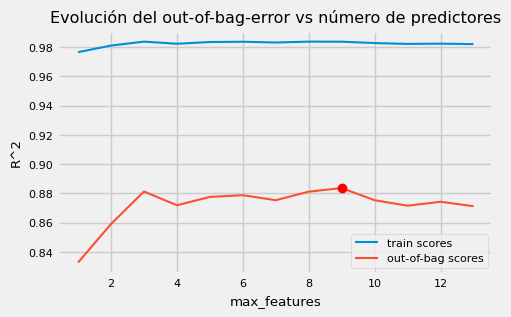

In [ ]:
# Validación empleando el Out-of-Bag error
train_scores = []
oob_scores   = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de Out-of-Bag.
for max_features in max_features_range:
    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelo.fit(X_train, y_train)
    train_scores.append(modelo.score(X_train, y_train))
    oob_scores.append(modelo.oob_score_)

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Valor óptimo de max_features: 9


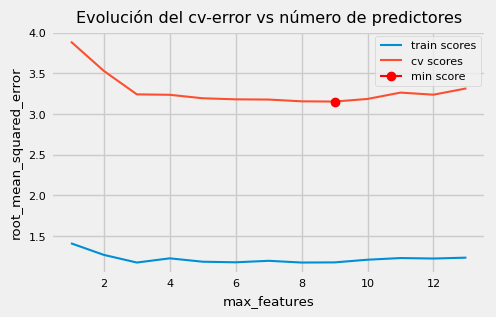

In [ ]:
# Validación empleando k-cross-validation y neg_root_mean_squared_error
# ==============================================================================
train_scores = []
cv_scores    = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1)

# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de k-cross-validation.
for max_features in max_features_range:

    modelo = RandomForestRegressor(
                n_estimators = 100,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )

    # Error de train
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X = X_train)
    rmse = root_mean_squared_error(
            y_true  = y_train,
            y_pred  = predicciones,
           )
    train_scores.append(rmse)

    # Error de validación cruzada
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'neg_root_mean_squared_error',
                cv        = 5
             )
    # Se agregan los scores de cross_val_score() y se pasa a positivo
    cv_scores.append(-1*scores.mean())

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, cv_scores, label="cv scores")
ax.plot(max_features_range[np.argmin(cv_scores)], min(cv_scores),
        marker='o', color = "red", label="min score")
ax.set_ylabel("root_mean_squared_error")
ax.set_xlabel("max_features")
ax.set_title("Evolución del cv-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmin(cv_scores)]}")

Acorde a las dos métricas utilizadas, el valor óptimo de max_features seri 9.

**Grid search**

Aunque el análisis individual de los hiperparámetros es útil para entender su impacto en el modelo e identificar rangos de interés, la búsqueda final no debe hacerse de forma secuencial, ya que cada hiperparámetro interacciona con los demás. Es preferible recurrir a grid search, random search o bayesian search para analizar varias combinaciones de hiperparámetros. Puede encontrarse más información sobre las estrategias de búsqueda en Machine learning con Python y Scikit-learn.

Grid Search basado en out-of-bag error
Más detalles en: Grid search de modelos Random Forest con out-of-bag error y early stopping.

In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20]
                }
             )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:

    modelo = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )

    modelo.fit(X_train, y_train)

    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.oob_score_)
    print(f"Modelo: {params} ✓")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Modelo: {'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 9, 'n_estimators': 150} ✓


,oob_r2,max_depth,max_features,n_estimators
2,0.884331,NaN,9.0,150.0
11,0.883992,20.0,9.0,150.0
8,0.881925,10.0,9.0,150.0
6,0.881273,10.0,5.0,150.0


Este proceso de búsqueda puede paralelizarse para aprovechar todos cores del ordenador.

In [ ]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [150],
                 'max_features': [5, 7, 9],
                 'max_depth'   : [None, 3, 10, 20]
                }
             )

# Loop paralelizado para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
def eval_oob_error(X, y, params, verbose=True):
    """
    Función para entrenar un modelo utilizando unos parámetros determinados
    y que devuelve el out-of-bag error
    """
    modelo = RandomForestRegressor(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
            )

    modelo.fit(X, y)

    if verbose:
        print(f"Modelo: {params} ✓")

    return{'params': params, 'oob_r2': modelo.oob_score_}

resultados = Parallel(n_jobs=cpu_count()-1)(
                delayed(eval_oob_error)(X_train, y_train, params)
                for params in param_grid
             )

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Modelo: {'max_depth': None, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': None, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': None, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': 3, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': 10, 'max_features': 9, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 5, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 7, 'n_estimators': 150} ✓
Modelo: {'max_depth': 20, 'max_features': 9, 'n_estimators': 150} ✓


,oob_r2,max_depth,max_features,n_estimators
2,0.884331,NaN,9.0,150.0
11,0.883992,20.0,9.0,150.0
8,0.881925,10.0,9.0,150.0
6,0.881273,10.0,5.0,150.0


In [ ]:
# Mejores hiperparámetros por out-of-bag error
print("Mejores hiperparámetros encontrados (oob-r2)")
print("--------------------------------------------")
print(resultados.iloc[0,0:])

Mejores hiperparámetros encontrados (oob-r2)
--------------------------------------------
oob_r2            0.884331
max_depth              NaN
max_features      9.000000
n_estimators    150.000000
Name: 2, dtype: float64


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Grid Search basado en validación cruzada

Warning

La busqueda de hiperparámetros debe hacerse utilizando datos que el modelo no ha visto. Si se emplean los mismos datos para ajustar el modelo y para evaluarlo, se corre el riesgo de sobreajustar el modelo a los datos de entrenamiento. Para evitar este problema se puede recurrir a dos estrategias:

Dividir el conjunto de datos en tres grupos: entrenamiento, validación y test. El conjunto de entrenamiento se emplea para ajustar el modelo, el de validación para seleccionar el valor óptimo de los hiperparámetros y el de test para evaluar la capacidad predictiva del modelo.

Utilizar validación cruzada con los datos de entrenamiento. En este caso, el conjunto de entrenamiento se divide en k grupos y se ajusta el modelo k veces, cada vez con un grupo distinto como conjunto de validación. La métrica final es el promedio de los valores obtenidos en cada iteración. Esta estrategia es computacionalmente más costosa, ya que requiere entrenar el modelo k veces, pero evita tener que crear una partición adicional de los datos cuando no se dispone de muchos.

In [ ]:
# Grid de hiperparámetros evaluados
param_grid = {'n_estimators': [150],
              'max_features': [5, 7, 9],
              'max_depth'   : [None, 3, 10, 20]
             }

# Búsqueda por grid search con validación cruzada
grid = GridSearchCV(
            estimator  = RandomForestRegressor(random_state = 123),
            param_grid = param_grid,
            scoring    = 'neg_root_mean_squared_error',
            n_jobs     = cpu_count() - 1,
            cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123),
            refit      = True,
            verbose    = 0,
            return_train_score = True
       )

grid.fit(X=X_train, y=y_train)

# Resultados
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
7,10,7,150,-3.268617,0.749109,-1.297217,0.079266
9,20,5,150,-3.269340,0.772228,-1.223492,0.063941
0,None,5,150,-3.271604,0.773610,-1.223805,0.063681
10,20,7,150,-3.271879,0.764815,-1.233534,0.066160


In [ ]:
# Mejores hiperparámetros encontrados mediante validación cruzada
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'max_depth': 10, 'max_features': 7, 'n_estimators': 150} : -3.268616632469091 neg_root_mean_squared_error


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Una vez identificados los mejores hiperparámetros, se reentrena el modelo indicando los valores óptimos en sus argumentos. Si en el GridSearchCV() se indica refit=True, este reentrenamiento se hace automáticamente y el modelo resultante se encuentra almacenado en .best_estimator_.

In [ ]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X=X_test)
rmse = root_mean_squared_error(
        y_true  = y_test,
        y_pred  = predicciones,
       )
print(f"El error (rmse) de test es: {rmse}")

El error (rmse) de test es: 3.878169750398715


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Tras optimizar los hiperparámetros, se consigue reducir el error rmse del modelo de 4.35 a 3.55. Las predicciones del modelo final se alejan en promedio 3.55 unidades (3550 dólares) del valor real.

Bayesian search¶
**texto en negrita**
La búsqueda grid search y random search pueden generar buenos resultados, sobre todo cuando se reduce el rango de exploración. Sin embargo, ninguna de ellas tiene en cuenta los resultados obtenidos hasta el momento, lo que les impide centrar la búsqueda en las regiones de mayor interés y evitar las innecesarias.

Una alternativa es utilizar métodos de optimización bayesiana para buscar hiperparámetros. En términos generales, la optimización bayesiana de hiperparámetros consiste en crear un modelo probabilístico en el que la función objetivo es la métrica de validación del modelo (RMSE, AUC, precisión...). Con esta estrategia, la búsqueda se redirige en cada iteración a las regiones de mayor interés. El objetivo final es reducir el número de combinaciones de hiperparámetros con las que se evalúa el modelo, eligiendo sólo los mejores candidatos. Este enfoque es especialmente ventajoso cuando el espacio de búsqueda es muy grande o la evaluación del modelo es muy lenta

In [ ]:
# Búsqueda bayesiana de hiperparámetros con optuna
# ==============================================================================
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 100),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 100),
        'max_features': trial.suggest_float('max_features', 0.2, 1.0),
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.0, 1),
        # Fixed parameters
        'n_jobs': -1,
        'random_state': 4576688,

    }

    modelo = RandomForestRegressor(**params)
    cross_val_scores = cross_val_score(
        estimator = modelo,
        X = X_train,
        y = y_train,
        cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123),
        scoring = 'neg_root_mean_squared_error',
        n_jobs=-1
    )
    score = np.mean(cross_val_scores)
    return score

study = optuna.create_study(direction='maximize') # Se maximiza por que el score es negativo
study.optimize(objective, n_trials=30, show_progress_bar=True, timeout=60*5)

print('Mejores hyperparameters:', study.best_params)
print('Mejor score:', study.best_value)

  0%|          | 0/30 [00:00<?, ?it/s]

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
# Error de test del modelo final
# ==============================================================================
modelo_final = RandomForestRegressor(**study.best_params)
modelo_final.fit(X_train, y_train)
predicciones = modelo_final.predict(X=X_test)
rmse = root_mean_squared_error(y_true=y_test, y_pred=predicciones)
print(f"El error (rmse) de test es: {rmse}")

In [ ]:
# Importancia de los predictores basada en la reducción de la impureza
# ==============================================================================
importancia_predictores = pd.DataFrame({
                            'predictor': datos.drop(columns = "MEDV").columns,
                            'importancia': modelo_final.feature_importances_
                          })
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

In [ ]:
# Importancia de los predictores basada en permutación
# ==============================================================================
importancia = permutation_importance(
                estimator    = modelo_final,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

In [ ]:
# Gráfico de la importancia de cada predictor
# ==============================================================================
fig, ax = plt.subplots(figsize=(3.5, 4))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

Random Forest con XGBoost
XGBoost se utiliza principalmente para crear modelos de tipo gradient boosting, sin embargo, dado que los modelos de random forest utilizan la misma representación de árboles y la misma estrategia de predicción, es posible configurar XGBoost para que utilice el algoritmo de random forest durante el entrenamiento. La configuración de los parámetros para entrenar modelos random forest es:

booster debe ser en gbtree.

subsample debe ser en un valor menor que 1 para permitir la selección aleatoria de observaciones de entrenamiento (filas) en cada árbol.

Uno de los parámetros colsample_by* debe establecerse en un valor menor que 1 para permitir la selección aleatoria de columnas. Normalmente se utiliza colsample_bynode para seleccionar columnas de manera aleatoria en cada división de árbol.

num_parallel_tree indica el número de árboles que forman el modelo.

num_boost_round debe establecerse en 1 para evitar que XGBoost combine múltiples modelos random forest. Este es un argumento del método train(), y no de la inicialización.

eta (alias: learning_rate) debe ser 1.

Para facilitar el uso de modelos random forest con XGBoost, existen dos clases XGBRFClassifier y XGBRFRegressor. Se trata de versiones de XGBClassifier y XGBRegressor que ya tienen por defecto el valor de los parámetros que consigue el entrenamiento de random forest en lugar de gradient boosting.

n_estimators especifica el número de árboles. Internamente se convierte en num_parallel_tree.

learning_rate se establece en 1 de forma predeterminada.

colsample_bynode y subsample se establecen en 0.8 de forma predeterminada.

booster es siempre gbtree.

✎ Note

El principal beneficio de utilizar la librería XGBoost para entrenar modelos random forest frente a la implementación nativa de scikit-learn es la velocidad junto con su capacidad para manejar valores faltantes y variables categóricas.

⚠ Warning

La implementación de XGBoost tiene algunas diferencias con respecto a la implementación de scikit-learn que pueden llevar a resultados diferentes.
XGBoost utiliza una aproximación de segundo orden a la función objetivo. Esto puede llevar a resultados que difieren de una implementación que utiliza el valor exacto de la función objetivo.
XGBoost no realiza reemplazos al seleccionar observaciones de entrenamiento. Cada valor de entrenamiento puede aparecer como máximo una vez en cada muestreo.

In [ ]:
from xgboost import XGBRFRegressor
import xgboost
print(f"Versión de XGBoost: {xgboost.__version__}")

# Descarga de datos
# ==============================================================================
url = (
    'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/'
    'master/data/Boston.csv'
)
datos = pd.read_csv(url, sep=',')
datos.head(3)

# División de los datos en entrenamiento y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "MEDV"),
                                        datos['MEDV'],
                                        random_state = 123
                                    )
# Creación del modelo
# ==============================================================================
modelo = XGBRFRegressor(
            n_estimators     = 100,
            tree_method      = 'hist',
            max_depth        = 10,
            max_leaves       = 5,
            learning_rate    = 1.0,
            subsample        = 0.8,
            colsample_bynode = 0.8,
            reg_lambda       = 1e-05,
            reg_alpha        = 0,
        )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)

In [ ]:
# Predicciones
# ==============================================================================
predicciones = modelo.predict(X_test)

# Error de test
# ==============================================================================
rmse = root_mean_squared_error(y_true=y_test, y_pred=predicciones)
print(f"El error (rmse) de test es: {rmse}")

Random Forest con LightGBM¶
Al igual que ocurre con XGBoost, los LightGBM también pueden configurarse para entrenar modelos random forest en lugar de gradient boosting.

In [ ]:
from lightgbm import LGBMRegressor
import lightgbm
print(f"Versión de LightGBM: {lightgbm.__version__}")

# División de los datos en entrenamiento y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop(columns = "MEDV"),
                                        datos['MEDV'],
                                        random_state = 123
                                    )
# Creación del modelo
# ==============================================================================
modelo = LGBMRegressor(
            boosting_type="rf",
            n_estimators=50,
            max_depth=10,
            colsample_bytree=0.8,
            subsample=0.8,
            subsample_freq=1,
            reg_alpha= 1, # L1 regularización
            reg_lambda= 1, # L2 regularización
            verbose=-1
         )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)

In [ ]:
# Predicciones
# ==============================================================================
predicciones = modelo.predict(X_test)
predicciones

# Error de test
# ==============================================================================
rmse = root_mean_squared_error(y_true=y_test, y_pred=predicciones)
print(f"El error (rmse) de test es: {rmse}")